In [18]:
import json
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go

In [19]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

from pandas.api.types import is_numeric_dtype

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


In [20]:
from sklearn.utils import shuffle

In [21]:
os.getcwd()
pd.set_option('display.max_columns', 100)

In [22]:
df_gen_tweets = pd.read_csv('datasets_full.csv/genuine_accounts.csv/tweets.csv')
df_gen_users = pd.read_csv('datasets_full.csv/genuine_accounts.csv/users.csv')

print(len(df_gen_tweets)/len(df_gen_users))

df_gen = pd.merge(df_gen_tweets, df_gen_users, how = 'left',left_on='user_id', right_on='id')

C:\Users\motoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



817.3177892918826


In [23]:
df_bot1_tweets = pd.read_csv('datasets_full.csv/social_spambots_1.csv/tweets.csv')
df_bot1_users = pd.read_csv('datasets_full.csv/social_spambots_1.csv/users.csv')
df_bot1_merge = pd.merge(df_bot1_tweets, df_bot1_users, how = 'left', left_on='user_id', right_on='id')

df_bot2_tweets = pd.read_csv('datasets_full.csv/social_spambots_2.csv/tweets.csv')
df_bot2_users = pd.read_csv('datasets_full.csv/social_spambots_2.csv/users.csv')
df_bot2_merge = pd.merge(df_bot2_tweets, df_bot2_users, how = 'left', left_on='user_id', right_on='id')

df_bot3_tweets = pd.read_csv('datasets_full.csv/social_spambots_3.csv/tweets.csv')
df_bot3_users = pd.read_csv('datasets_full.csv/social_spambots_3.csv/users.csv')
df_bot3_merge = pd.merge(df_bot3_tweets, df_bot3_users, how = 'left', left_on='user_id', right_on='id')

C:\Users\motoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\motoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.



In [24]:
df_bot4_tweets = pd.read_csv('datasets_full.csv/traditional_spambots_1.csv/tweets.csv')
df_bot4_users = pd.read_csv('datasets_full.csv/social_spambots_1.csv/users.csv')
df_bot4_merge = pd.merge(df_bot4_tweets, df_bot4_users, how = 'left', left_on='user_id', right_on='id')

In [25]:
df_bot = pd.concat([df_bot2_merge, df_bot3_merge, df_bot4_merge])

C:\Users\motoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [26]:
len(df_gen), len(df_bot)

(2839362, 1992193)

In [27]:
df_gen['bot']=0
df_bot['bot']=1

In [29]:
df_gen_no_dup = df_gen.drop_duplicates(subset = 'user_id', keep = 'first')
df_bot_no_dup = df_bot.drop_duplicates(subset = 'id_y', keep = 'first')

number = 1000

df_all = pd.concat([df_gen_no_dup.sample(number), df_bot_no_dup.sample(number)])

C:\Users\motoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [30]:
#define data cleaning functions

#cleaning step 1: check if screen_name has a word 'bot' in it

def screen_name_check (df):
    
    word = 'bot'
    bot_name = []
    k = 0

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['screen_name']):
                k = 0
        else: 
            if word in df.iloc[i,:]['screen_name']:
                k = 1
            else:
                k = 0
        bot_name.append(k)
    
    return bot_name


#cleaning step 2: check if location parameter is present

def location_check(df):
    
    loc = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['location']):
            loc.append(0)
        else:
            loc.append(1)
            
    return loc

# cleaning step 3
# Set description to 1 if it contains either of these words: 
#‘bot’, ‘robot’, ‘artificial’, ‘intelligence’, ‘neural’, ‘network’, ‘automatic’ and 0 otherwise.

def description_check(df):
    keyword = ['bot', 'robot', 'artificial', 'intelligence', 'neural', 'network', 'automatic']
    bot_des = []
    k = 0

    for i in range (len(df)):
        for keyword in keyword:
            if pd.isnull(df.iloc[i,:]['description']):
                k = 0
            else:
                if df.iloc[i,:]['description'].find(keyword) == -1:
                    k = 0
                else:
                    k = 1
        bot_des.append(k)
        
    return bot_des

#cleaning step 4:
#Set verified to 1 if the sample’s verified features contents are True and 0 otherwise.

def verified_check(df):
    ver = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['verified']):
            ver.append(0)
        else:
            ver.append(1)
    return ver

#cleaning step 5:
#Check if default profile exists or not.

def default_profile_check (df):
    
    default_profile = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile']):
            default_profile.append(0)
        else:
            default_profile.append(1)
    
    return default_profile

#cleaning step 6:
#Check if default profile image is used or not.

def default_image_check (df):
    
    default_profile_image = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile_image']):
            default_profile_image.append(0)
        else:
            default_profile_image.append(1)
    
    return default_profile_image

In [31]:
def master_clean (df):
    bot_name = screen_name_check (df)
    loc = location_check (df)
    bot_des = description_check (df)
    ver = verified_check (df)
    default_profile = default_profile_check (df)
    default_profile_image = default_image_check (df)
    
    df = pd.DataFrame({'tweet':df['text'], 
                       'screen_name': df['screen_name'],
                       'name': df['name'],
                       'bot_in_name':bot_name,
                       'bot_in_des':bot_des,
                       'location': loc,
                       'verified': ver,
                       'default_profile': default_profile,
                       'default_profile_image': default_profile_image,
                       'followers_count': df['followers_count'],
                       'listed_count': df['listed_count'],
                       'friends_count': df['friends_count'],
                       'favourites_count': df['favourites_count'],
                       'statuses_count': df['statuses_count'],
                       'bot_or_not':df['bot']
                       })
    
    return df

In [32]:
df_clean = master_clean(df_all)

In [33]:
'''
Converts features ‘followers_count’, ‘listed_count’, ‘friends_count’, 
‘favorites_count’, ‘statuses_count’ from string to int and 
normalizes their values. (for KNN algorithm implementation)
'''

def normalize (df):
    con_var = ['followers_count', 'listed_count', 'friends_count', 'favourites_count', 'statuses_count']

    for var in con_var:
        x = df[var]
        x = (x - x.mean())/x.std()
        df[var + str(2)] = x


(backup for removing outliers) 
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df


con_var = ['followers_count', 'listed_count', 'friends_count', 'favourites_count', 'statuses_count']

for var in con_var:
    df_clean[var] = remove_outlier(df_clean[[var]])

df_clean = df_clean.dropna()

In [34]:
df_clean.head()

,tweet,screen_name,name,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count,bot_or_not
2414065,"You should read ""poems"" on #Wattpad #poetry ht...",Gaara823,Alex Estrada,0,0,1,0,1,0,36.0,0.0,229.0,41.0,36.0,0
1709995,Boracay! :) http://t.co/sxNH7TTXX9,emeraldgayle,Emerald Fabillar,0,1,1,0,0,0,179.0,4.0,339.0,257.0,2485.0,0
2078683,@fion_li @NiuB great place. Like a giant free ...,koonnang,Koonnang,0,0,1,0,1,0,123.0,3.0,702.0,59.0,666.0,0
1545738,RT @CBS6Cody: Good morning! Time to wake up an...,CBS6Albany,CBS 6 Albany - WRGB,0,0,1,1,0,0,27856.0,605.0,756.0,291.0,54344.0,0
729205,"this is exciting, ambulance just pulled up in ...",andyinsdca,andyinsdca,0,0,1,0,0,0,534.0,22.0,860.0,41.0,16942.0,0


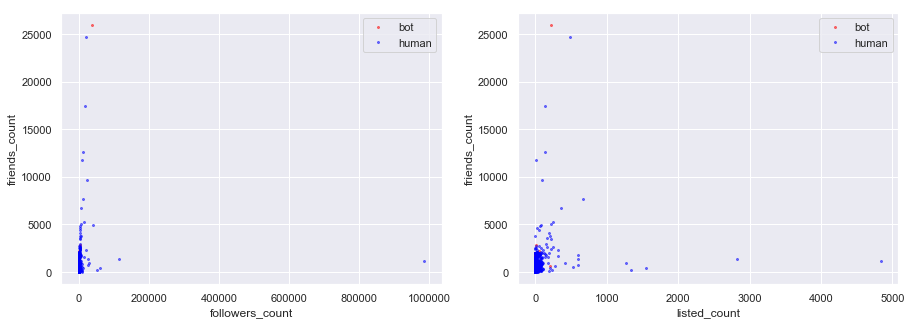

In [35]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].plot(df_clean[df_clean['bot_or_not']==1]['followers_count'],
         df_clean[df_clean['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = 2, alpha = 0.5, label = 'bot')

ax[0].plot(df_clean[df_clean['bot_or_not']==0]['followers_count'],
         df_clean[df_clean['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = 2, alpha = 0.5, label = 'human')
ax[0].set_xlabel('followers_count')
ax[0].set_ylabel('friends_count')
ax[0].legend()

ax[1].plot(df_clean[df_clean['bot_or_not']==1]['listed_count'],
         df_clean[df_clean['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = 2, alpha = 0.5, label = 'bot')

ax[1].plot(df_clean[df_clean['bot_or_not']==0]['listed_count'],
         df_clean[df_clean['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = 2, alpha = 0.5, label = 'human')
ax[1].set_xlabel('listed_count')
ax[1].set_ylabel('friends_count')
ax[1].legend()

Text(0.5,0,'statuses_count')

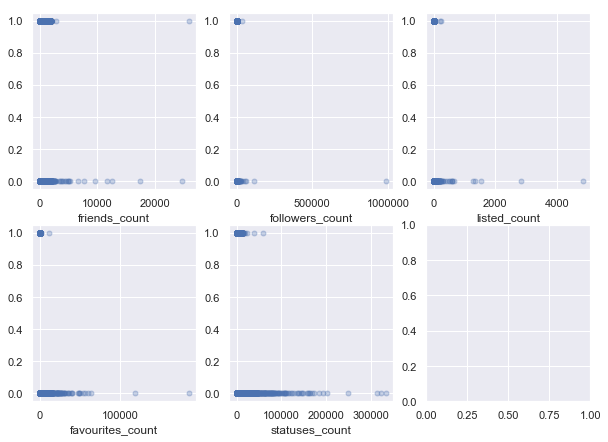

In [36]:
fig, ax = plt.subplots (2,3, figsize = (10,3))
fig.subplots_adjust(bottom = -0.8, top = 1)

size = 5

ax[0,0].plot(df_clean['friends_count'], df_clean['bot_or_not'], 'o', markersize = size, alpha =0.3)
ax[0,0].set_xlabel('friends_count')

ax[0,1].plot(df_clean['followers_count'], df_clean['bot_or_not'], 'o', markersize = size, alpha =0.3)
ax[0,1].set_xlabel('followers_count')

ax[0,2].plot(df_clean['listed_count'], df_clean['bot_or_not'], 'o', markersize = size, alpha =0.3)
ax[0,2].set_xlabel('listed_count')

ax[1,0].plot(df_clean['favourites_count'], df_clean['bot_or_not'], 'o', markersize = size, alpha =0.3)
ax[1,0].set_xlabel('favourites_count')

ax[1,1].plot(df_clean['statuses_count'], df_clean['bot_or_not'], 'o', markersize = size, alpha =0.3)
ax[1,1].set_xlabel('statuses_count')

Text(0.5,1,'favourites_count')

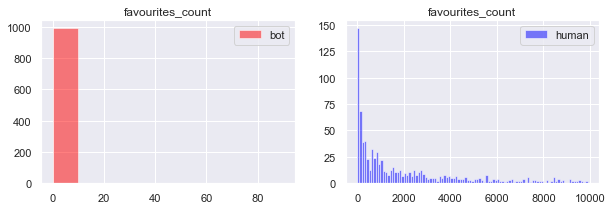

In [37]:
fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'favourites_count'

ax[0].hist(df_clean[df_clean['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 100, 10))

ax[0].legend()

ax[1].hist(df_clean[df_clean['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 10000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'friends_count')

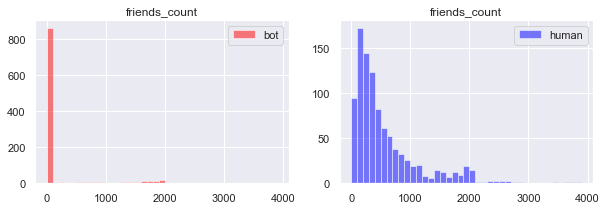

In [38]:
fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'friends_count'

ax[0].hist(df_clean[df_clean['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 4000, 100))

ax[0].legend()
ax[1].hist(df_clean[df_clean['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 4000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'followers_count')

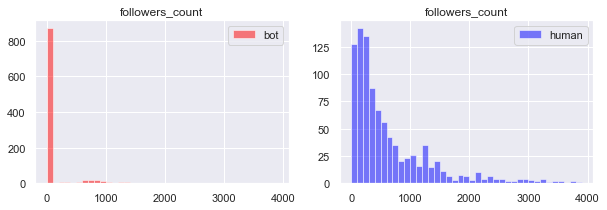

In [39]:
fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'followers_count'

ax[0].hist(df_clean[df_clean['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 4000, 100))

ax[0].legend()
ax[1].hist(df_clean[df_clean['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 4000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'listed_count')

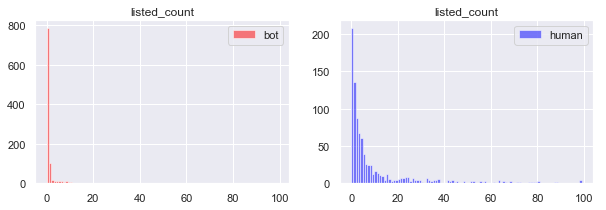

In [40]:
fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'listed_count'

ax[0].hist(df_clean[df_clean['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 100, 1))

ax[0].legend()
ax[1].hist(df_clean[df_clean['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 100, 1))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'statuses_count')

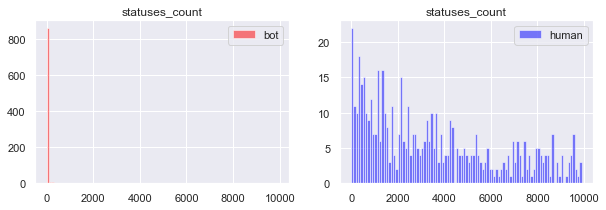

In [41]:
fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'statuses_count'

ax[0].hist(df_clean[df_clean['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 10000, 100))

ax[0].legend()
ax[1].hist(df_clean[df_clean['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 10000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

In [42]:
df_clean_2 = df_clean.drop(columns=['tweet', 'screen_name','name']).dropna()
df_clean_3 = shuffle(df_clean_2)

In [43]:
df_X = df_clean_3.drop(columns='bot_or_not')
df_y = df_clean_3[['bot_or_not']]

In [44]:
display(df_X.head())
display(df_y.head())

,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count
701774,0,1,0,0,0,0,4520.0,0.0,230.0,89.0,416.0
2104380,0,1,0,0,1,0,524.0,1.0,510.0,4532.0,9352.0
219222,0,0,0,0,0,0,6.0,0.0,29.0,0.0,55.0
1085798,0,1,1,0,1,0,283.0,1.0,225.0,956.0,2071.0
1072834,0,1,0,0,1,0,652.0,2.0,1198.0,0.0,9904.0


,bot_or_not
701774,0
2104380,0
219222,1
1085798,0
1072834,1


In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.2, shuffle = True)

In [46]:
depth = 100
N = 100

rf_model = RandomForestClassifier(n_estimators = N, criterion='gini', 
                                  max_features='auto', max_depth = depth, bootstrap=True,
                                 oob_score=True)

rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_score = accuracy_score(y_train, y_pred_train) * 100
test_score = accuracy_score(y_test, y_pred_test) * 100

oobs_score = rf_model.oob_score_

print('accuracy score of the training set is {}%'.format(train_score))
print('accuracy score of the test set is {}%'.format(test_score))

C:\Users\motoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



accuracy score of the training set is 100.0%
accuracy score of the test set is 98.5%


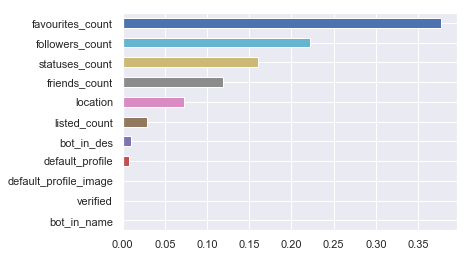

In [47]:
pd.Series(rf_model.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh")